In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy 
import datetime as dt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy




Using TensorFlow backend.


In [2]:

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=2):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #print("1")
    #scaler = scaler.fit(train)
    #print("1")
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    print("1")
    train_scaled = scaler.transform(train)
    print("1")
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    print("1")
    test_scaled = scaler.transform(test)
    print("1")
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(1, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=50, batch_size=batch_size, verbose=1, shuffle=False)
    # model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [3]:
register_matplotlib_converters()
countries = ["USA.csv", "GERMANY.csv", "BRASIL.csv", "NETHERLANDS.csv"]

In [4]:
def load_data(file_name, scaler):
    data = pd.read_csv("C:/Users/OPTIMUSPRIME/Desktop/Studia/Eksploracja danych/Project/" + file_name)
    data.fillna(0, inplace=True)
#     print(data.columns)
    data_after_year = data.loc[data["Date"] > "2011-00-00"]
    data_after_year = data_after_year.loc[data_after_year["Date"] < "2019-00-00"]
    bank_values = data_after_year.values[:,1]
    if scaler is not None:
        bank_values = numpy.reshape(scaler.fit_transform(numpy.reshape(bank_values, newshape=(-1,1))), newshape=(1,-1))[0]
    dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in data_after_year.values[:, 0]]
    return dates, bank_values

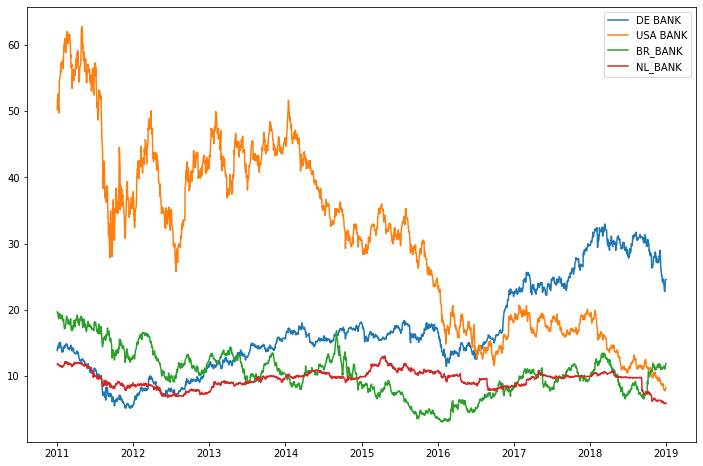

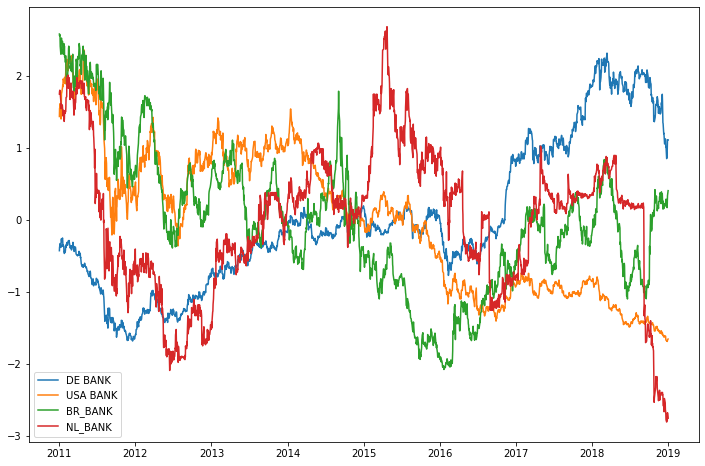

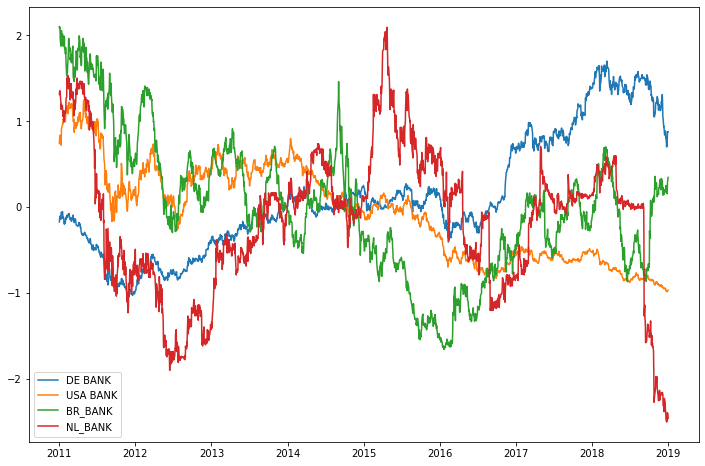

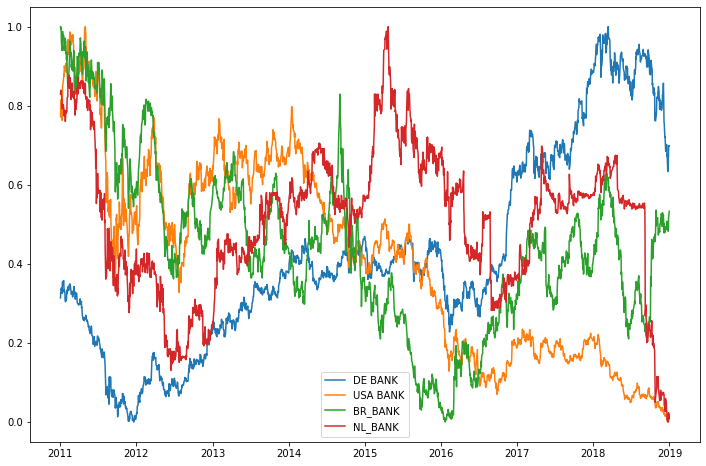

In [7]:
scalers = [None, StandardScaler(), RobustScaler(), MinMaxScaler()]
temp=1
for scaler in scalers:
    bal = plt.figure(figsize=(12,8))
    for country in countries:
        dates, bank_values = load_data(country, scaler)
        plt.plot(dates, bank_values)
        plt.grid()
        plt.legend(("DE BANK", "USA BANK", "BR_BANK", "NL_BANK"))
#     bal.savefig("blalba" + str(temp) + ".png")
#     temp = temp + 1

In [133]:
percentageDivision = 0.2

dates, supervised_values = load_data(countries[3], MinMaxScaler())
raw_values = supervised_values
diff_values = difference(raw_values, 1)
from math import floor
time_step = 4
X = list()
last_index = len(supervised_values)
overlapping = int(time_step / 2)
last_possible_index = (floor(last_index / time_step) - 1) * time_step
for index in range(0, last_possible_index + overlapping + 1, overlapping):
    X.append(supervised_values[index: index + time_step])
supervised_values = numpy.array(X)
# split data into train and test-sets
train, test = supervised_values[0:-int(percentageDivision*len(supervised_values))], supervised_values[-int(percentageDivision*len(supervised_values)):]
print(test)


[array([0.6031856 , 0.59141274, 0.60180055, 0.59072022])
 array([0.60180055, 0.59072022, 0.58587258, 0.58310249])
 array([0.58587258, 0.58310249, 0.58725762, 0.58725762])
 array([0.58725762, 0.58725762, 0.57756233, 0.58033241])
 array([0.57756233, 0.58033241, 0.5734072 , 0.57853186])
 array([0.5734072 , 0.57853186, 0.5699446 , 0.56939058])
 array([0.5699446 , 0.56939058, 0.57063712, 0.56648199])
 array([0.57063712, 0.56648199, 0.56648199, 0.56301939])
 array([0.56648199, 0.56301939, 0.57867036, 0.57880886])
 array([0.57867036, 0.57880886, 0.57686981, 0.56246537])
 array([0.57686981, 0.56246537, 0.55720222, 0.5567867 ])
 array([0.55720222, 0.5567867 , 0.56481994, 0.55429363])
 array([0.56481994, 0.55429363, 0.56509695, 0.53199446])
 array([0.56509695, 0.53199446, 0.53047091, 0.53753463])
 array([0.53047091, 0.53753463, 0.53144044, 0.53185596])
 array([0.53144044, 0.53185596, 0.52770083, 0.53185596])
 array([0.52770083, 0.53185596, 0.52908587, 0.52908587])
 array([0.52908587, 0.52908587,

In [134]:
#scaler, train_scaled, test_scaled = scale(train, test)
# fit the model
lstm_model = fit_lstm(train, 1, 5, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train[:, :-1].reshape(len(train), 1, time_step-1)
lstm_model.predict(train_reshaped, batch_size=1)

IndexError: too many indices for array

In [135]:
predictions = list()
for i in range(len(test)):
    # make one-step forecast
    X, y = test[i, 0:-1], test[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    #yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    #yhat = inverse_difference(raw_values, yhat, len(test)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

IndexError: too many indices for array

In [136]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-int(percentageDivision*len(supervised_values)):], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-int(percentageDivision*len(supervised_values)):])
pyplot.plot(predictions)
pyplot.show()

ValueError: Found input variables with inconsistent numbers of samples: [204, 0]